# Week 09 - Topic Modeling - Latent Dirichlet Allocation

------

Welcome back! Today, we'll work on a very useful text analysis technique called Topic Modeling. Particularly, we will use its most popular and powerful algorithm: Latent Dirichlet Allocation, or LDA

Before you implement your own LDA on STAN, it is important that you understand all concepts well. In this notebook, we'll start by playing a little bit with the Dirichlet distribution. After this, we'll ask you to do some ancestral sampling on the LDA generative story.

Only after that, you'll do your own LDA in STAN. 


We start by the usual imports

In [1]:
import pystan
import pystan_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1 - Understanding the dirichlet distribution

The Dirichlet distribution is available as numpy.random.dirichlet(alpha, size=None)

...so, try it! For example, obtain draws from this distribution using different values of alpha.

In [2]:
print(np.random.dirichlet([.2,.2, .2]))
print(np.random.dirichlet([.1,.1, .9]))
print(np.random.dirichlet([1,1, 1]))

[0.91713956 0.00278888 0.08007156]
[2.48892248e-04 1.08662637e-04 9.99642445e-01]
[0.93947891 0.00627168 0.05424941]


Check that the sum is always 1, for all vectors...

In [3]:
np.sum(np.random.dirichlet([.2,.2, .2]))

1.0

Whenever you can, try to visualize it. Remember what we did in the slides. Try to do the same thing!

**feel free to use the function below, to plot points from a dirichlet distribution, onto a 2D simplex**

In [4]:
'''Function to plot points in a simplex'''

# Based on post from Thomas Boggs (http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/)

import matplotlib.tri as tri

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])

def plot_points(X):
    '''Plots a set of points in the simplex.

    Arguments:

        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
    '''
    
    X = X.dot(_corners)  #This is what converts the original points onto the simplex (it projects on it, through dot product)
    plt.plot(X[:, 0], X[:, 1], 'k.', ms=1)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.triplot(_triangle, linewidth=1)

Generate 10000 points from the dirichlet distribution and plot them using the function above

In [5]:
points = np.random.dirichlet([.09, .09, .09], size=1000)

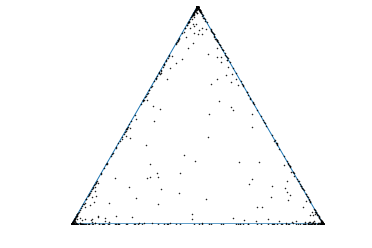

In [6]:
plot_points(points)

Try with different values of $\alpha$

Notice that $\alpha = [1,1,1]$ corresponds to a uniform distribution. Values of $\alpha < 1$ lead to sparse distributions (can be used as sparsity-inducing priors!). The higher the value of $\alpha$, the more concentrated is the distribution.

----------------

## Part 2: LDA Ancestral Sampling

We define our own dictionary of 30 words. There are 3 different topics that we embedded in the dictionary, can you see what they are?

In [7]:
K = 3
dictionary =["Copenhagen",
             "Madrid",
             "Sydney",
             "Kabul",
             "Vienna",
             "Brussels",
             "Beijing",
             "Kathmandu",
             "Singapore",
             "Oslo",
             "blue",
             "green",
             "beige",
             "cyan",
             "black",
             "tan",
             "brown",
             "orange",
             "white",
             "red",
             "data",
             "model",
             "inference",
             "learning",
             "observation",
             "dimension",
             "training",
             "neuralnetwork",
             "analytics",
             "sampling"
             ]
C = len(dictionary)

To make it smoother and more fun, we'll start by giving you the topics, $\phi$ and the proportions $\theta$ directly. I.e., you don't need to generate (yet) those from Dirichlet distribution.

Lets start by defining the 3 topics. We do this by assigning a probability for each word under of the 3 topics ($\phi$).

In [8]:
## Define word vectors (for each topic) and normalize:
phi = np.zeros( (K, C) );
phi[0] = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
phi[0] *= 1/np.sum(phi[0])
phi[1] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
phi[1] *= 1/np.sum(phi[1])
phi[2] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
phi[2] *= 1/np.sum(phi[2])

Notice that for topic 1, we assigned high probability to the words: Copenhagen, Madrid, Sydney, Kabul, Vienna, Brussels, Beijing, Kathmandu, Singapore, Oslo. 

Similarly, for topic 2, we assigned high probability to the words: blue, green, ...

Finaly, for topic 3, we assigned high probability to the words: model, inference, ...

Now that we have defined the probability of each word under each topic, we can follow the generative process to sample some documents. As previously mentioned, we will pre-define the distribution over topics for each document ($\theta$):

In [9]:
I = 3 ## Number of documents.

## Define topic proportion vectors (one for for each document):
theta = np.zeros( (I, K) );
theta[0] = [0.6, 0.2, 0.2]
theta[1] = [1/3, 1/3, 1/3] ## This one will be an equal mix of all topics
theta[2] = [  0,   0,  1] ## This will for example only contain topic 3.

Notice that the first document has higher probability of containing words from topic 1 than topics 2 and 3. Document 2 is uniform - all topics have equal probability. Document 3 covers exclusevely topic 3.

Let us now generate the 3 documents following the generative process:

So, you assume now that we have $\boldsymbol{\theta}_i$ for all documents and $\boldsymbol{\phi}_k$ for all topics. Ancestral sampling is simply:


For each document $i$, and for each word $j=1...w_i$, do:
\begin{align}
z_{i, j} &\sim Cat(\boldsymbol{\theta}_i) \\
w_{i, j} &\sim Cat(\boldsymbol{\phi}_{z_{i,j}})
\end{align}



Can you try code it down yourself?

In [10]:
##Just to make things practical, we created this function for you
## just read it or, try it, to see what it does...
def categorical_sample(p):
    return list(np.random.multinomial(1, p)).index(1)

In [11]:
## function that receives document sizes J, theta (topic proportions) and phi (topics), 
## returns z (word-topic assignments ) and w (words)
def ancestral_sampling(J, theta, phi):
    ## Initialise
    z = np.zeros( (I, np.max(J)), dtype=int )  #NOTICE that z and w are vectors of integers!
    w = np.zeros( (I, np.max(J)), dtype=int )  

    '''
    TODO: write your code here
    '''
    for i in range(I):
        for j in range(J[i]):
            z[i,j] = categorical_sample(theta[i])
            w[i,j] = categorical_sample(phi[z[i,j]])
    return z, w

In [12]:
J = [12, 9, 10] ## Vector of size I denoting how many words are in each document
z, w = ancestral_sampling(J, theta, phi)
print("w:", w)
for i in range(I):
    print("\n\nDocument: ", i)
    print("Theta: ", theta[i])
    for j in range(J[i]):
        print("Word %d: Topic assignment: %d->   %s  " % (j,  z[i, j]+1, dictionary[w[i, j]]))

w: [[ 7  8 28 10  5 13 13 15  8  3  0 27]
 [10 24 23 29  3 13 14  8  8  0  0  0]
 [25 20 26 23 23 21 22 23 24 24  0  0]]


Document:  0
Theta:  [0.6 0.2 0.2]
Word 0: Topic assignment: 1->   Kathmandu  
Word 1: Topic assignment: 1->   Singapore  
Word 2: Topic assignment: 3->   analytics  
Word 3: Topic assignment: 2->   blue  
Word 4: Topic assignment: 1->   Brussels  
Word 5: Topic assignment: 2->   cyan  
Word 6: Topic assignment: 2->   cyan  
Word 7: Topic assignment: 2->   tan  
Word 8: Topic assignment: 1->   Singapore  
Word 9: Topic assignment: 1->   Kabul  
Word 10: Topic assignment: 1->   Copenhagen  
Word 11: Topic assignment: 3->   neuralnetwork  


Document:  1
Theta:  [0.33333333 0.33333333 0.33333333]
Word 0: Topic assignment: 2->   blue  
Word 1: Topic assignment: 3->   observation  
Word 2: Topic assignment: 3->   learning  
Word 3: Topic assignment: 3->   sampling  
Word 4: Topic assignment: 1->   Kabul  
Word 5: Topic assignment: 2->   cyan  
Word 6: Topic assignment:

Don't forget to take a look at the generated documents? Do they make sense, given the values for $\phi$ and $\theta$ given above?


We bet you guessed what we want you to do next: having generated yourself the data, can you make an LDA model in STAN that recovers the original parameters $\phi$ and $\theta$?

A dataset with only 3 documents is too little of course. So, let's generate 100 documents intead, by using the dirichlet distribution. In other words, we will generate:
- vectors $\theta_1 \dots \theta_I$
- a new vector $J$ that contains their sizes, with $J_i \sim Poisson(10)$


In [13]:
I=100
theta = np.zeros((I, K));
alpha = 0.5*np.ones(K) ## Size K dirichlet prior
J=[]

for i in range(I):
    theta[i] = np.random.dirichlet(alpha);
    J.append(int(np.random.poisson(10)))
_, W = ancestral_sampling(J, theta, phi)

Please reuse your code to generate the dataset W. Please reuse $\phi$ as before

## Part 3 - Implement your own LDA model in STAN

It is time to make your own model in STAN! :-) Go for it!

In [14]:
LDA_STAN="""
data{
  int<lower=0> I;           // Number of documents
  int<lower=0> J[I];        // Number of words in each document
  int<lower=0> MAX_J;       // Max number of words in all the documents
  int<lower=0> K;           // Number of topics
  int<lower=0> C;           // Dictionary size (Total number of words)
  vector[K]    alpha;       // Dirichlet prior for document's topic distribution (theta)
  vector[C]    beta;        // Dirichlet prior for topic's word distribution
  int<lower=0> W[I, MAX_J]; // Documents consisting of j words
}
parameters{
  simplex[K] theta[I]; // Topic distribution in each document
  simplex[C] phi[K];   // Distribution of words in each topic
}
model{
  for (i in 1:I){
    theta[i] ~ dirichlet(alpha);
  }
  for (k in 1:K){
    phi[k]   ~ dirichlet(beta);
  }
  
  for (i in 1:I){
    for (j in 1:J[i]){
      real gamma[K];
      for (k in 1:K){
        // log(p(z=k|theta)) + log(p(w|phi, z=k))
        gamma[k] = log(theta[i,k]) + log(phi[k, W[i,j]]); // indexes of theta and phi change because they are defined as repetitions of rows(?)
      }
      target += log_sum_exp(gamma); // target is a protected variable to sum on the log likelihood
    }
  }
}
"""

## Compile the model
sm = pystan.StanModel(model_code=LDA_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16f46dd087fdbdd3cc0497c194130279 NOW.


In [15]:
beta = 0.5*np.ones(C) ## Size C dirichlet prior, for topic word distributions

In [16]:
## Collect the data
data={'I':I, 'J':J, 'K':K, 'C':C, 'alpha':alpha, 'beta':beta, 'MAX_J':np.max(J), 'W':W+1}
## Sample with VB
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)

Extract results from STAN:

In [17]:
theta_hat = pystan_utils.vb_extract_variable(fit, "theta", var_type="matrix", dims=[I,K])
phi_hat = pystan_utils.vb_extract_variable(fit, "phi", var_type="matrix", dims=[K,C])

Compare estimated $\hat{\phi}$ with true values of $\phi$ used to generate the data:

In [18]:
np.argmax(phi, axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [19]:
np.argmax(phi_hat, axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

Notice anything interesting? Do the results match exactly? Remember that if we call "topic 1" -> "topic 2", and we call "topic 2" -> "topic 1", the resulting model is still the same! We just "renamed" the topics. This is another case of the problem of model identifiability...

